# Project 15. Diversity in the Workplace

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
plt.style.use('ggplot')

import scipy.stats as ss

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split,RandomizedSearchCV, GridSearchCV
from sklearn.metrics import mean_squared_error
from sklearn.feature_selection import chi2

from sklearn.preprocessing import MinMaxScaler
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

import xgboost as xgb

# Table of Contents
  1. [Read Data](#readdata)
  2. [Answer to question 1](#answertoquestion1)
  3. [Answer to question 2](#answertoquestion2)
  4. [Answer to question 3](#answertoquestion3)

<a id='read_data'></a>
## Read Data

In [3]:
# import data first and use the employee_id as the index
company = pd.read_csv('~/company_hierarchy.csv', index_col = 'employee_id')
company.head()

,boss_id,dept
employee_id,,
46456,175361.0,sales
104708,29733.0,HR
120853,41991.0,sales
142630,171266.0,HR
72711,198240.0,sales


In [4]:
company.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 46456 to 144338
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   boss_id  9999 non-null   float64
 1   dept     10000 non-null  object 
dtypes: float64(1), object(1)
memory usage: 234.4+ KB


In [5]:
company['dept'].unique()

array(['sales', 'HR', 'engineering', 'marketing', 'CEO'], dtype=object)

<a id='answertoquestion1'></a>
## Answer to question 1
In the company there are 6 levels(CEO, E, VP, D, MM, ID). Identify each employee's correspoinding level

In [6]:
# First we add all the levels in a list
levels = ['CEO', 'E', 'VP', 'D', 'MM', 'IC']
# Since we just check 'CEO' is one of the company's department, so we can define its level directly
company.loc[company['dept'] == 'CEO','level'] = 'CEO'

# Since the boss levels occupy the indice from 0 to 4 in the levels, and the lase is the employee who don't manage anyone, we start from the biggest boss
for i in range(0, len(levels)-1):
    boss_level = levels[i]
    employee_level = levels[i + 1]
    boss_id = company[company['level'] == boss_level].index
    company.loc[company['boss_id'].isin(boss_id), 'level'] = employee_level

In [7]:
company.head()

,boss_id,dept,level
employee_id,,,
46456,175361.0,sales,IC
104708,29733.0,HR,IC
120853,41991.0,sales,IC
142630,171266.0,HR,MM
72711,198240.0,sales,IC


In [8]:
# discard other irrelavent information, just show the employee ids and their levels
company.drop(['boss_id', 'dept'],axis = 1).head()

,level
employee_id,
46456,IC
104708,IC
120853,IC
142630,MM
72711,IC


In [9]:
# show how many persons in each level 
company['level'].value_counts()

IC     9000
MM      800
D       160
VP       35
E         4
CEO       1
Name: level, dtype: int64

<a id='answertoquestion2'></a>
## Answer to question 2
How many people each employee manages? You should have a table with employee ids and the number of people manages.

In [10]:
# add CEO's counts to the dataframe, CEO's number of people manages is all employees but himself
company['counts'] = 0

for level in ['IC', 'MM', 'D', 'VP', 'E']:
    boss_ids = company[company['level'] == level]['boss_id']
    employee_ids = company[company['level'] == level].index
    
    for boss_id, employee_id in zip(boss_ids, employee_ids):
        boss_count = company[company['boss_id'] == boss_id]['counts'].count()
        employee_count = company[company['boss_id'] == employee_id]['counts'].count()
        company.loc[company.index == boss_id,'counts'] = boss_count + employee_count

In [11]:
# add CEO's counts to the dataframe, CEO's number of people manages is all employees but himself
company.loc[company['level']=='CEO','counts'] = 9999

# show the employee ids and the corresponding numbers of people manages.
company[['level','counts']].head()

,level,counts
employee_id,,
46456,IC,0
104708,IC,0
120853,IC,0
142630,MM,16
72711,IC,0


<a id='answertoquestion3'></a>
## Answer to question 3
Build a model to predict the salary of each employee.
### Data Cleaning and formatting

In [12]:
# load another file
employee = pd.read_csv('~/employee.csv', index_col = 'employee_id')
employee.head()

,signing_bonus,salary,degree_level,sex,yrs_experience
employee_id,,,,,
138719,0,273000.0,Master,M,2
3192,0,301000.0,Bachelor,F,1
114657,0,261000.0,Master,F,2
29039,0,86000.0,High_School,F,4
118607,0,126000.0,Bachelor,F,3


In [13]:
# join two table together
data = employee.join(company)
data.head()

,signing_bonus,salary,degree_level,sex,yrs_experience,boss_id,dept,level,counts
employee_id,,,,,,,,,
138719,0,273000.0,Master,M,2,43602.0,engineering,IC,0
3192,0,301000.0,Bachelor,F,1,87847.0,sales,IC,0
114657,0,261000.0,Master,F,2,180854.0,sales,IC,0
29039,0,86000.0,High_School,F,4,88370.0,HR,IC,0
118607,0,126000.0,Bachelor,F,3,23565.0,sales,IC,0


In [14]:
data.describe()

,signing_bonus,salary,yrs_experience,boss_id,counts
count,10000.000000,10000.000000,10000.000000,9999.000000,10000.000000
mean,0.301400,189111.800000,3.875200,103299.980498,2.199500
std,0.458889,88973.796898,3.107409,57508.798817,100.050276
min,0.000000,60000.000000,1.000000,79.000000,0.000000
25%,0.000000,110000.000000,2.000000,55883.000000,0.000000
50%,0.000000,182000.000000,3.000000,102712.000000,0.000000
75%,1.000000,255000.000000,5.000000,152288.000000,0.000000
max,1.000000,700000.000000,34.000000,199950.000000,9999.000000


### EDA 

In [15]:
# Before we do any further EDA, we first delete some irrelevant fields, which have no effect on the target.
final = data.copy()
final.drop(['boss_id'],axis=1,inplace = True)
final.head()

,signing_bonus,salary,degree_level,sex,yrs_experience,dept,level,counts
employee_id,,,,,,,,
138719,0,273000.0,Master,M,2,engineering,IC,0
3192,0,301000.0,Bachelor,F,1,sales,IC,0
114657,0,261000.0,Master,F,2,sales,IC,0
29039,0,86000.0,High_School,F,4,HR,IC,0
118607,0,126000.0,Bachelor,F,3,sales,IC,0


#### Distribution of target

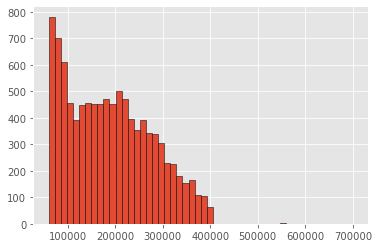

In [16]:
# check the distribution of salary
final['salary'].hist(bins=50,edgecolor='black')

From above histogram of salary, there are two phenomenon: **1)** salary's distribution is **highly skewed**, which increase the difficulty on regression. I can transfer the original data to log values; **2)** There are **outlier(s)** in the salary, which are far more than the normal ditribution of salary, I should drop that.

#### 1) Transfer target field and make it more balanced

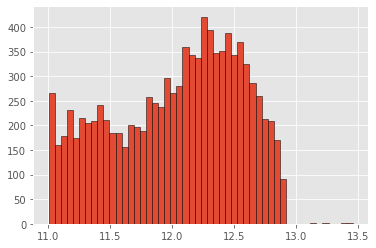

In [17]:
final['salary'] = np.log(final['salary'])
final['salary'].hist(bins = 50, edgecolor='black')

After the log transformation, the distribution of salary is more balanced.

#### 2) Check outlier and remove

In [18]:
# Outlier are extreme values. One of its definationa are any data values which lie more than 3 times the interquartile range below the first quartile or above the thir quartile. Therefore, the lower end will be 'First Quartile - 3 * Interquartile Range', and the higher end will be 'Third Quartile + 3 * Interquartile Range'
first_quantile = final['salary'].describe()['25%']
third_quantile = final['salary'].describe()['75%']

# Interquartile range
iqr = third_quantile - first_quantile

# remove the outliers
final = final[(final['salary'] > (first_quantile - 3*iqr)) & (final['salary'] < (third_quantile + 3*iqr))]

In [19]:
final.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10000 entries, 138719 to 72227
Data columns (total 8 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   signing_bonus   10000 non-null  int64  
 1   salary          10000 non-null  float64
 2   degree_level    10000 non-null  object 
 3   sex             10000 non-null  object 
 4   yrs_experience  10000 non-null  int64  
 5   dept            10000 non-null  object 
 6   level           10000 non-null  object 
 7   counts          10000 non-null  int64  
dtypes: float64(1), int64(3), object(4)
memory usage: 703.1+ KB


In [20]:
final.describe()

,signing_bonus,salary,yrs_experience,counts
count,10000.000000,10000.000000,10000.000000,10000.000000
mean,0.301400,12.026718,3.875200,2.199500
std,0.458889,0.515792,3.107409,100.050276
min,0.000000,11.002100,1.000000,0.000000
25%,0.000000,11.608236,2.000000,0.000000
50%,0.000000,12.111762,3.000000,0.000000
75%,1.000000,12.449019,5.000000,0.000000
max,1.000000,13.458836,34.000000,9999.000000


From the above information, we can easily found that there are no NaN values in the dataset, and the outlier has been dropped.

#### Looking for relationships between categorical variables and target

In order to look at the effect of categorical variables on the target, we can make a **density plot** colored by the value of the categorical variable. Density plots show the distribution of a single variable and can be thought of as a smoothed histogram. When we color the density curve by a categorical variable, this will show how the distribution changes based on the class.

Text(0.5, 1.0, 'Salary by degree_level')

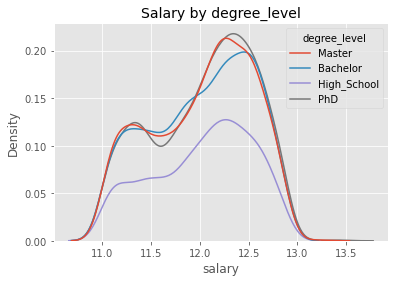

In [21]:
# check the relathionships between "degree_level" and salary
sns.kdeplot(x='salary',data=final, hue='degree_level')
plt.title('Salary by degree_level', size = 14)

It can be seen that the "degree_level" have some effect on the "salary". We should include this feature in the model. Since for any categorical variales, it has to be one-hot encoded before it is fed into a machine learning model.And we'll do that later.

Text(0.5, 1.0, 'Salary by sex')

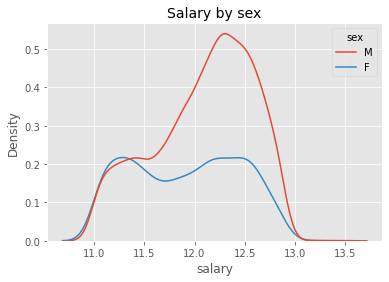

In [22]:
# Check the relationship between "sex" and salary
sns.kdeplot(data = final,x = 'salary',hue ='sex')
plt.title('Salary by sex', size = 14)

C:\Users\xiaoj\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Salary by level')

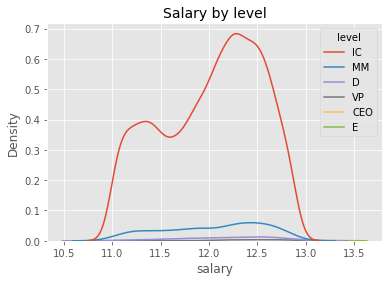

In [23]:
# Check the relationship between "dept" and "salary"
sns.kdeplot(x='salary',data = final, hue='level')
plt.title('Salary by level', size = 14)

C:\Users\xiaoj\anaconda3\lib\site-packages\seaborn\distributions.py:306: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


Text(0.5, 1.0, 'Salary by Department')

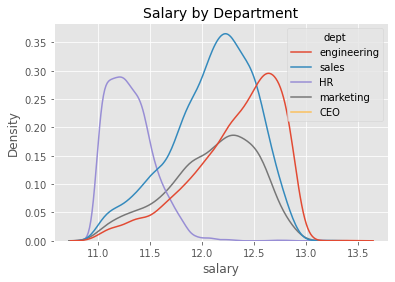

In [24]:
# Check the relationship between dep and salary
sns.kdeplot(x = 'salary',data = final, hue='dept')
plt.title('Salary by Department', size = 14)

Same with "degree_level", it can be found that "sex","level","dept" does have effects on the "salary". So we should include all these four categorical variables when building the model.Before building the ML model, we need to firstly transfer them to be numerical.

#### Correlation coefficients between features and target
Here I use **Pearson correlation coefficient** to calculate the strength and direction of the linear relationship between feature and target. Although there can be non-linear relationships between the features and target, and correlation coefficients don't account for such non-linear relationships, linear relationships are still a good way to explore trends in the data. We can use them to select the features to employ in the ML model.

In [25]:
final.corr()['salary'].sort_values()

counts            0.029262
yrs_experience    0.042502
signing_bonus     0.113890
salary            1.000000
Name: salary, dtype: float64

To account for possible non-linear relationships, we take square root and natural log transformations of the numeric features and then calculate the correlation coefficients with the salary. At the same time, to capture any possible relationships between the categorical and salary, we will have to one-hot encode these features.

In [26]:
# Select the numeric features
numerical_subset = final.select_dtypes('number')

# Create features with square root and log
for col in numerical_subset.columns:
    # Skip the target 'Salary' column:
    if col == 'salary':
        next
    else:
        numerical_subset['sqrt_' + col] = np.sqrt(numerical_subset[col])
        numerical_subset['log_' + col] = np.log(numerical_subset[col])


<ipython-input-26-63e67a55deae>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerical_subset['sqrt_' + col] = np.sqrt(numerical_subset[col])
C:\Users\xiaoj\anaconda3\lib\site-packages\pandas\core\series.py:679: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)
<ipython-input-26-63e67a55deae>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  numerical_subset['log_' + col] = np.log(numerical_subset[col])


In [27]:
# Choose the categorical features and transfer them to be numerical
categorical_subset = final[['level','degree_level','dept','sex']]
categorical_subset = pd.get_dummies(categorical_subset)

# Join the categorical and numerical features together
new_features = pd.concat([numerical_subset, categorical_subset], axis = 1)

# check the correlations between features
correlations = new_features.corr()['salary'].dropna().sort_values()
correlations

dept_HR                    -0.621766
sex_F                      -0.168012
level_IC                   -0.035639
degree_level_Bachelor      -0.009800
degree_level_Master        -0.006085
degree_level_High_School   -0.000629
level_MM                    0.009792
degree_level_PhD            0.016287
log_yrs_experience          0.023182
level_CEO                   0.027768
dept_CEO                    0.027768
counts                      0.029262
sqrt_yrs_experience         0.031795
level_D                     0.033925
yrs_experience              0.042502
level_VP                    0.043405
sqrt_counts                 0.046787
level_E                     0.046887
dept_marketing              0.065929
log_counts                  0.093532
dept_sales                  0.106644
signing_bonus               0.113890
sqrt_signing_bonus          0.113890
sex_M                       0.168012
dept_engineering            0.350067
salary                      1.000000
Name: salary, dtype: float64

After transforming the features, the strongest relationships are related to department. And sex also have some effect on the salary. We can use these correlations in order to perform feature selection.

### Feature Engineering and Feature Selection
We have explored the trends and relationships within the data, we can work on engineering a set of features for our models. We can use the results of EDA to inform the feature engineering. In particular, from EDA we learned the following:
- The salary distribution is skewed and the log transformation of salary would increase the distribution balance. 
- The salary distribution varies by department and to a lesser extent by sex.


In this project, we will take the following steps for feature engineering:
- Select one numerical features(signing_bonus) and two categorical variables(department and sex)
- one-hot encode the categorical variable
- use the log transformation of the salary

In [28]:
# Since not all features have great effects to the salary, we choose only those > 0.1
correlations = correlations[abs(correlations) > 0.1]
correlations.index

Index(['dept_HR', 'sex_F', 'dept_sales', 'signing_bonus', 'sqrt_signing_bonus',
       'sex_M', 'dept_engineering', 'salary'],
      dtype='object')

In [29]:
# Choose the target feature
y = new_features['salary']
y.shape

(10000,)

In [30]:
# Choose the most important features to build the ML models
new_features = new_features[correlations.index].drop(['salary'],axis=1)
new_features.shape

(10000, 7)

### Split dataset

In [31]:
# split into 70% training and 30% testing
x_train, x_test, y_train, y_test = train_test_split(new_features,y, test_size = 0.3, random_state = 42)

### Establish a Baseline

If the models we build can't outperform a naive guess then we might have to admit that ML is not suited. This could be because we are not using the right models, or we need more data. A good naive baseline is to predict the median value of the target on the training set for all examples on the test set. If our models can't do better than guessing the median value, then we will need to rethink out approach.

In [32]:
# Define the function to calculate the mean absolute error between true values and predictions
def mae(y_true, y_pred):
    return np.mean(abs(y_true - y_pred))

In [33]:
# Make the median guess and evaluate it on the test set
baseline_guess = np.median(y)

print('The baseline guess is a score of %0.2f' % baseline_guess)
print('Baseline Performance on the test set: MAE = %0.4f' % mae(y_test, baseline_guess))

The baseline guess is a score of 12.11
Baseline Performance on the test set: MAE = 0.4299


### Build the model

In this section, we will build, train and evaluate several ML methods for our supervised regression task. The objective is to determine which model is best.

#### 1) Check Missing Values
Standard ML models can't deal with missing values, which means we need to double check if there are any missing values. If yes, we neen to fill in thses missing values.

In [34]:
new_features.isnull().count()

dept_HR               10000
sex_F                 10000
dept_sales            10000
signing_bonus         10000
sqrt_signing_bonus    10000
sex_M                 10000
dept_engineering      10000
dtype: int64

It can be seen that there are no null values in the current dataset.

#### 2) Scaling Features
The final step to take before we build out models is to scale the features. This is necessary because features are sometimes in different units, and we need to normalize the features so the units don't affect the algorithm.

In [35]:
# Create the scaler object with a range of 0-1
scaler = MinMaxScaler(feature_range=(0,1))

# Fit on the training data
scaler.fit(x_train)

# Transform both the training and testing data
x_train= scaler.transform(x_train)
x_test = scaler.transform(x_test)

#### 3）Models to Evaluate
I will compare five different ML models using Scikit-learn library:
1. Linear Regression
2. Support Vector Machine Regression
3. Random Forest Regression
4. Gradient Boosting Regression
5. K-Nearest Neighbors Regression


To compare the models, I will use the Scikit-Learn defaults for the model hyperparameters. Generally these will perform decently, but should be optimized before actually using a model. At first, we just want to determine the baseline performance of each model, then select the best one for further optimization using hyperparameter tuning.

In [36]:
# Funtion to calculate mean absolute error
def mae(y_true,y_pred):
    return np.mean(abs(y_true - y_pred))

# Take in a model, train the model, and evaluate the model on the test set
def fit_and_evaluate(model):
    # Train the model
    model.fit(new_features,y)
    
    # Make the predictions and evaluate
    model_pred = model.predict(x_test)
    model_mae = mae(y_test, model_pred)
    
    # Return the performance metric
    return model_mae    

In [37]:
lr = LinearRegression()
lr_mae = fit_and_evaluate(lr)

print('Linear Regression Performance on the test set: MAE = %0.4f' % lr_mae)

Linear Regression Performance on the test set: MAE = 0.3100


In [38]:
svm = SVR(C = 1000, gamma = 0.1)
svm_mae = fit_and_evaluate(svm)

print('Support Vector Machine Regression Performance on the test set: MAE = %0.4f' % svm_mae)

Support Vector Machine Regression Performance on the test set: MAE = 0.3060


In [39]:
random_forest = RandomForestRegressor(random_state=60)
random_forest_mae = fit_and_evaluate(random_forest)

print('Random Forest Regression Performance on the test set: MAE = %0.4f' % random_forest_mae)

Random Forest Regression Performance on the test set: MAE = 0.3095


In [40]:
gradient_boosting = GradientBoostingRegressor(random_state=60)
gradient_boosting_mae = fit_and_evaluate(gradient_boosting)

print('Gradient Boosting Regression Performance on the test set: MAE = %0.4f' % gradient_boosting_mae)

Gradient Boosting Regression Performance on the test set: MAE = 0.3097


In [41]:
knn = KNeighborsRegressor(n_neighbors=10)
knn_mae = fit_and_evaluate(knn)

print('K-Nearest Neighbors Regression Performance on the test set: MAE = %0.4f' % knn_mae)

K-Nearest Neighbors Regression Performance on the test set: MAE = 0.3272


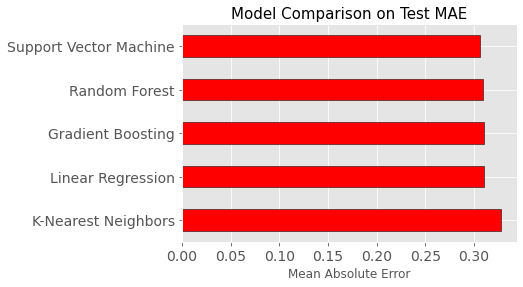

In [42]:
# Dataframe to hold the results
model_comparison = pd.DataFrame({'model': ['Linear Regression', 'Support Vector Machine',
                                           'Random Forest', 'Gradient Boosting',
                                            'K-Nearest Neighbors'],
                                 'mae': [lr_mae, svm_mae, random_forest_mae, 
                                         gradient_boosting_mae, knn_mae]})

# Horizontal bar chart of test mae
models = model_comparison.sort_values('mae', ascending = False)
models.plot(x = 'model', y = 'mae', kind = 'barh',color = 'red', edgecolor = 'black',legend=False)

# Plot formatting
plt.ylabel(''); plt.yticks(size = 14)
plt.xlabel('Mean Absolute Error'); plt.xticks(size = 14)
plt.title('Model Comparison on Test MAE', size = 15);

It can be seen that the SVM performs the best followed by random forest. Of couser there are some unfair becasue I used mostly the default hyperparameters.Nonetheless, for these results, we can conclude that machine learning is applicable because all the models significantly outperform the baseline!


From here, I am going to concentrate on optimizing the best model using hyperparameter tuning. Since during the above tests, the SVM is obviously slower than all the other models and the MAE values are bacially same, I will concentrate on using the **gradient boosting**.

### Model Optimization
In this section, I will try to find the best set of hyperparameters for the chosen model

#### 1) hyperparameters tuning with grid search and cross validation
I will first choose the best hyperparameters for the model through **grid search and cross validation**.

In [44]:
# Loss function to be optimized
loss = ['ls', 'lad', 'huber']

# Number of trees used in the boosting process
n_estimators = [200, 300, 500, 800, 1000]

# Maximum depth of each tree
max_depth = [4, 5, 6, 8, 12,15]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# Minimum number of samples to split a node
min_samples_split = [6, 8, 10,12,16]

# Maximum number of features to consider for making splits
max_features = ['auto', 'sqrt', 'log2', None]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'loss':loss,
                      'n_estimators': n_estimators,
                      'max_depth':max_depth,
                      'min_samples_leaf':min_samples_leaf,
                      'min_samples_split': min_samples_split,
                      'max_features': max_features}

In [45]:
# I will create a randomized search object and trained it.
model = GradientBoostingRegressor(random_state = 60)

# Set up the random search with 5-fold cross validation
grid_search = GridSearchCV(estimator = model,
                         param_grid = hyperparameter_grid,
                         cv = 5,
                         scoring = 'neg_mean_absolute_error',
                         n_jobs = -1,
                         verbose = 1,
                         return_train_score = True
                         )

# Fit on the training data
grid_search.fit(x_train,y_train)

Fitting 5 folds for each of 9000 candidates, totalling 45000 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   16.1s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 434 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 784 tasks      | elapsed:  5.0min
[Parallel(n_jobs=-1)]: Done 1234 tasks      | elapsed:  7.5min
[Parallel(n_jobs=-1)]: Done 1784 tasks      | elapsed: 10.5min
[Parallel(n_jobs=-1)]: Done 2434 tasks      | elapsed: 15.9min
[Parallel(n_jobs=-1)]: Done 3184 tasks      | elapsed: 22.7min
[Parallel(n_jobs=-1)]: Done 4034 tasks      | elapsed: 27.1min
[Parallel(n_jobs=-1)]: Done 4984 tasks      | elapsed: 33.4min
[Parallel(n_jobs=-1)]: Done 6034 tasks      | elapsed: 40.4min
[Parallel(n_jobs=-1)]: Done 7184 tasks      | elapsed: 47.1min
[Parallel(n_jobs=-1)]: Done 8434 tasks      | elapsed: 55.8min
[Parallel(n_jobs=-1)]: Done 9784 tasks      | elapsed: 63.7min
[Parallel(n_jobs=-1)]: Done 11234 tasks      |

TerminatedWorkerError: A worker process managed by the executor was unexpectedly terminated. This could be caused by a segmentation fault while calling the function or by an excessive memory usage causing the Operating System to kill the worker.


In [ ]:
# After training, I can get the best performing one
grid_search.best_estimator_

However, since the last process took really too long(take several house to finish, and before it finish, it suffer an unexpected terminated. to save the time, I just listed the code, but not executed it )

#### 2) hyperparameters tuning with random search and cross validation
Then I will choose the best hyperparameters for the model through **random search and cross validation**. Random search refers to the method in which we choose hyperparameter to evaluate: we first define a range of options, and then randomly select combination to try. This is in contrast to grid search which evaluate every single combination we specify. Generally, random search is better when we have limited knowledge of the best model hyperparameters and we can use it to narrow down the options and then use grid search with a more limited range of options. And random search is much faster than grid search. 

In [44]:
# Loss function to be optimized
loss = ['ls', 'lad', 'huber']

# Number of trees used in the boosting process
n_estimators = [200, 300, 500, 800, 1000]

# Maximum depth of each tree
max_depth = [4, 5, 6, 8, 12,15]

# Minimum number of samples per leaf
min_samples_leaf = [1, 2, 4, 6, 8]

# Minimum number of samples to split a node
min_samples_split = [6, 8, 10,12,16]

# Maximum number of features to consider for making splits
max_features = ['auto', 'sqrt', 'log2', None]

# Define the grid of hyperparameters to search
hyperparameter_grid = {'loss':loss,
                      'n_estimators': n_estimators,
                      'max_depth':max_depth,
                      'min_samples_leaf':min_samples_leaf,
                      'min_samples_split': min_samples_split,
                      'max_features': max_features}

In [45]:
# I will create a randomized search object and trained it.
model = GradientBoostingRegressor(random_state = 60)

# Set up the random search with 5-fold cross validation
random_cv = RandomizedSearchCV(estimator = model,
                               param_distributions = hyperparameter_grid,
                               cv = 5,
                               n_iter = 40,
                               scoring = 'neg_mean_absolute_error',
                               n_jobs = -1,
                               verbose = 1,
                               return_train_score = True,
                               random_state = 60)

# Fit on the training data
random_cv.fit(x_train,y_train)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   46.0s
[Parallel(n_jobs=-1)]: Done 184 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 200 out of 200 | elapsed:  2.9min finished


RandomizedSearchCV(cv=5, estimator=GradientBoostingRegressor(random_state=60),
                   n_iter=40, n_jobs=-1,
                   param_distributions={'loss': ['ls', 'lad', 'huber'],
                                        'max_depth': [4, 5, 6, 8, 12, 15],
                                        'max_features': ['auto', 'sqrt', 'log2',
                                                         None],
                                        'min_samples_leaf': [1, 2, 4, 6, 8],
                                        'min_samples_split': [6, 8, 10, 12, 16],
                                        'n_estimators': [200, 300, 500, 800,
                                                         1000]},
                   random_state=60, return_train_score=True,
                   scoring='neg_mean_absolute_error', verbose=1)

In [46]:
# After training, I will choose the best performing one
random_cv.best_estimator_

GradientBoostingRegressor(loss='lad', max_depth=4, max_features='sqrt',
                          min_samples_leaf=4, min_samples_split=12,
                          n_estimators=200, random_state=60)

**The best gradient boosting model has the following hyperparameters:**
- loss = lad
- n_estimators = 200
- max_depth = 4
- min_samples_leaf = 4
- min_samples_split = 12
- max_features = sqrt

As we can see, the random search results help us to narrow down the possible hyperparameters to try. We can use it to inform a grid search by creating a grid with hyperparamters close to those that worked best during the randomized search. However, insteadinf of evaluating all of these setting again, I will focus on a single one, the number of trees in forest. By varying only one hyperparameter, we can directly observe how it affect performance. 

In [47]:
# Create a range of trees to evaluate
trees_grid = {'n_estimators': [50, 100, 200, 250, 300]}

model = GradientBoostingRegressor(loss = 'lad', 
                                  max_depth = 4,
                                  min_samples_leaf = 4,
                                  min_samples_split = 12,
                                  max_features = 'sqrt',
                                  random_state = 60)

# Grid Search Object using the trees range and the random forest model
grid_search = GridSearchCV(estimator = model, 
                           param_grid=trees_grid, 
                           cv = 5, 
                           scoring = 'neg_mean_absolute_error', 
                           verbose = 1,
                           n_jobs = -1, 
                           return_train_score = True)

# Fit the grid search
grid_search.fit(x_train, y_train)

Fitting 5 folds for each of 5 candidates, totalling 25 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 out of  25 | elapsed:    7.3s finished


GridSearchCV(cv=5,
             estimator=GradientBoostingRegressor(loss='lad', max_depth=4,
                                                 max_features='sqrt',
                                                 min_samples_leaf=4,
                                                 min_samples_split=12,
                                                 random_state=60),
             n_jobs=-1, param_grid={'n_estimators': [50, 100, 200, 250, 300]},
             return_train_score=True, scoring='neg_mean_absolute_error',
             verbose=1)

Text(0.5, 1.0, 'Performance vs Number of Trees')

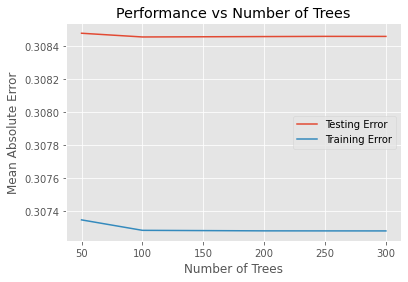

In [48]:
# Get the results into a dataframe
results = pd.DataFrame(grid_search.cv_results_)

# Plot the training and testing error vs number of trees
plt.plot(results['param_n_estimators'], -1 * results['mean_test_score'], label='Testing Error')
plt.plot(results['param_n_estimators'], -1 * results['mean_train_score'], label = 'Training Error')
plt.xlabel('Number of Trees')
plt.ylabel('Mean Absolute Error')
plt.legend()
plt.title('Performance vs Number of Trees')

From this plot, it's pretty clear that our model is good, since the training error and testing error didn't show great difference. If the training erros is significantly lower than the testing error, which means that the model is learning the training data very well, but then is not able to generalize to the test data as well. We should try and reduce overfiting. We can try to get more data, reduce the numbers of trees, reduce the max depth of each tree, increase the minimum number of samples in a leaf node.

### Evaluate Final Model on the Test Set
We will use the best model from hyperparameter tuning to make predictions on the testing set. For comparision, we can also look at the performance of the default model. The code below creates the final model, trains it, and evaluate on the test set.

In [70]:
final = GradientBoostingRegressor(loss = 'ls',
                                        learning_rate = 0.1,
                                        n_estimators = 150, 
                                        max_depth=4,
                                        max_features='sqrt',
                                        min_samples_leaf=4,
                                        min_samples_split=12,
                                        random_state=60,                                    
                                        verbose=1)

In [71]:
# Defaulst model
default_model = GradientBoostingRegressor(random_state = 60)

# Select the best model
final_model

GradientBoostingRegressor(loss='lad', max_depth=4, max_features='sqrt',
                          min_samples_leaf=4, min_samples_split=12,
                          random_state=60)

In [72]:
%%timeit -n 1 -r 5
default_model.fit(x_train, y_train)

144 ms ± 5.73 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [73]:
%%timeit -n 1 -r 5
final_model.fit(x_train, y_train)

282 ms ± 5.59 ms per loop (mean ± std. dev. of 5 runs, 1 loop each)


In [75]:
default_pred = default_model.predict(x_test)
final_pred = final_model.predict(x_test)

print('Default model performance on the test set: MAE = %0.4f.' % mae(y_test, default_pred))
print('Final model performance on the test set: MAE = %0.4f.' % mae(y_test, final_pred))

Default model performance on the test set: MAE = 0.3097.
Final model performance on the test set: MAE = 0.3073.


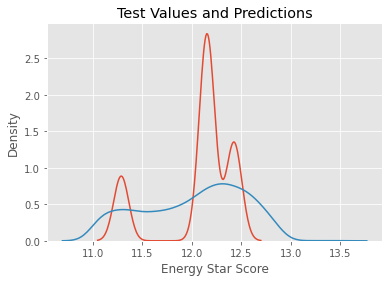

In [78]:
# Density plot of the final predictions and the test values
sns.kdeplot(final_pred, label = 'Predictions')
sns.kdeplot(y_test, label = 'Values')

# Label the plot
plt.xlabel('Energy Star Score')
plt.ylabel('Density');
plt.title('Test Values and Predictions');

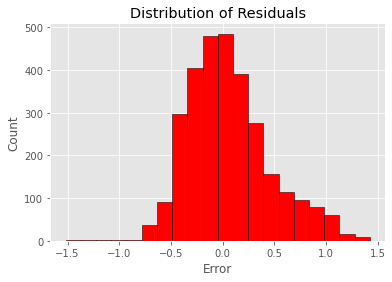

In [79]:
# Calculate the residuals 
residuals = final_pred - y_test

# Plot the residuals in a histogram
plt.hist(residuals, color = 'red', bins = 20,
         edgecolor = 'black')
plt.xlabel('Error'); plt.ylabel('Count')
plt.title('Distribution of Residuals');

### Feature Importances
One of the basic ways we can interpret an ensemble of decision trees is through what are known as the feature importances. These can be interpreted as the variables which are most predictive of the target. While the actual details of the feature importances are quite complex, we can use the relative values to compare the features and determine which are most relevant to the problem.

In [83]:
# Extract the feature importances into a dataframe
feature_results = pd.DataFrame({'feature': list(new_features.columns), 
                                'importance': final_model.feature_importances_})

# Show the top 10 most important
feature_results = feature_results.sort_values('importance', ascending = False).reset_index(drop=True)

feature_results.head(10)

,feature,importance
0,dept_HR,0.762187
1,dept_engineering,0.146649
2,dept_sales,0.048860
3,sex_F,0.025371
4,sex_M,0.009827
5,sqrt_signing_bonus,0.003868
6,signing_bonus,0.003238


The dept-HR and dept_engineering are the most important features. After that, the relative importance drops off considerably which indicates that we might not need to retain all of the features to create a model with nearly the same performance.

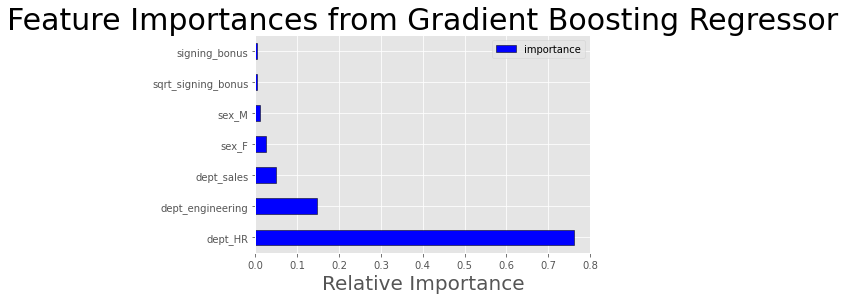

In [85]:
# Plot the 10 most important features in a horizontal bar chart
feature_results.loc[:9, :].plot(x = 'feature', y = 'importance', 
                                 edgecolor = 'k',
                                 kind='barh', color = 'blue');
plt.xlabel('Relative Importance', size = 20); plt.ylabel('')
plt.title('Feature Importances from Gradient Boosting Regressor', size = 30);

### XGBoost model
We also tried the XGBoost model, which has been proved to be very fast and efficient and become the most populat one in Kaggle competition.

In [153]:
import xgboost as xgb

In [115]:
train_matrix = xgb.DMatrix(x_train, y_train)
test_matrix = xgb.DMatrix(x_test)

In [132]:
reg_xgb = xgb.XGBRegressor(objective = 'reg:linear')

In [144]:
reg_xgb.fit(x_train,
           y_train,
           verbose = True,
           early_stopping_rounds = 10,
           eval_metric = 'rmse',
           eval_set = [(x_test,y_test)])

[14:30:49] WARNING: d:\bld\xgboost-split_1615294821523\work\src\objective\regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:8.07581
[1]	validation_0-rmse:5.65862
[2]	validation_0-rmse:3.96926
[3]	validation_0-rmse:2.79072
[4]	validation_0-rmse:1.97154
[5]	validation_0-rmse:1.40625
[6]	validation_0-rmse:1.02155
[7]	validation_0-rmse:0.76624
[8]	validation_0-rmse:0.60364
[9]	validation_0-rmse:0.50587
[10]	validation_0-rmse:0.45082
[11]	validation_0-rmse:0.42161
[12]	validation_0-rmse:0.40680
[13]	validation_0-rmse:0.39954
[14]	validation_0-rmse:0.39609
[15]	validation_0-rmse:0.39449
[16]	validation_0-rmse:0.39377
[17]	validation_0-rmse:0.39348
[18]	validation_0-rmse:0.39337
[19]	validation_0-rmse:0.39334
[20]	validation_0-rmse:0.39334
[21]	validation_0-rmse:0.39336
[22]	validation_0-rmse:0.39338
[23]	validation_0-rmse:0.39339
[24]	validation_0-rmse:0.39340
[25]	validation_0-rmse:0.39341
[26]	validation_0-rmse:0.39342
[27]	validation_0

XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=1, gamma=0, gpu_id=-1,
             importance_type='gain', interaction_constraints='',
             learning_rate=0.300000012, max_delta_step=0, max_depth=6,
             min_child_weight=1, missing=nan, monotone_constraints='()',
             n_estimators=100, n_jobs=8, num_parallel_tree=1,
             objective='reg:linear', random_state=0, reg_alpha=0, reg_lambda=1,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             validate_parameters=1, verbosity=None)

In [154]:
param_grid = {'max_depth': [3, 4, 5],
          'learning_rate': [0.1, 0.001, 0.05],
          'gamma': [0, 0.25, 1.0],
          'reg_lambda': [0, 1.0, 10.0],
          'scale_pos_weight': [1, 3, 5]}

optimal_params = GridSearchCV(estimator = reg_xgb,
                    param_grid = param_grid,
                    scoring = 'roc_auc',
                    verbose = 0,
                    n_jobs = 10,
                    cv = 3)



In [155]:
optimal_params.fit(x_train,y_train,
             verbose = True,
             early_stopping_rounds = 10,
             eval_metric = 'rmse',eval_set = [(x_test,y_test)])



ValueError: continuous format is not supported

In [ ]:

optimal_params.best_params_

In [116]:
params = {'eta':0.1,
          'subsample': 0.8,
          'max_depth': 5,
          'colsample_bytree': 0.8,
          'objective':'reg:linear',
          'eval_metric':'rmse',
          }

cv_results = xgb.cv(params,
                    train_matrix,
                    num_boost_round = 300,
                    nfold = params.get('nfold', 5),
                    metrics = params['eval_metric'],
                    verbose_eval = True,
                    early_stopping_rounds = 30,
                    seed = 42)

[14:11:37] WARNING: d:\bld\xgboost-split_1615294821523\work\src\objective\regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:11:37] WARNING: d:\bld\xgboost-split_1615294821523\work\src\objective\regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:11:37] WARNING: d:\bld\xgboost-split_1615294821523\work\src\objective\regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:11:37] WARNING: d:\bld\xgboost-split_1615294821523\work\src\objective\regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[14:11:37] WARNING: d:\bld\xgboost-split_1615294821523\work\src\objective\regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:10.38944+0.00338	test-rmse:10.38943+0.01484
[1]	train-rmse:9.35264+0.00268	test-rmse:9.35274+0.01465
[2]	train-rmse:8.41987+0.00220	test-rmse:8.42011+0.01431
[3]	train-rmse:7.58026+0.00175	test-rmse:7.5807

In [117]:
n_best_trees = cv_results.shape[0]
n_best_trees

84

In [118]:
watchlist=[(train_matrix,'train')]
gbt = xgb.train(params, train_matrix, n_best_trees, watchlist)

[14:11:41] WARNING: d:\bld\xgboost-split_1615294821523\work\src\objective\regression_obj.cu:170: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-rmse:10.38918
[1]	train-rmse:9.35248
[2]	train-rmse:8.42014
[3]	train-rmse:7.58061
[4]	train-rmse:6.82514
[5]	train-rmse:6.14549
[6]	train-rmse:5.53388
[7]	train-rmse:4.98425
[8]	train-rmse:4.48919
[9]	train-rmse:4.04398
[10]	train-rmse:3.64399
[11]	train-rmse:3.28431
[12]	train-rmse:2.96089
[13]	train-rmse:2.67033
[14]	train-rmse:2.40987
[15]	train-rmse:2.17555
[16]	train-rmse:1.96552
[17]	train-rmse:1.77760
[18]	train-rmse:1.60897
[19]	train-rmse:1.45830
[20]	train-rmse:1.32358
[21]	train-rmse:1.20343
[22]	train-rmse:1.09667
[23]	train-rmse:1.00178
[24]	train-rmse:0.91729
[25]	train-rmse:0.84340
[26]	train-rmse:0.77818
[27]	train-rmse:0.72104
[28]	train-rmse:0.67141
[29]	train-rmse:0.62782
[30]	train-rmse:0.59037
[31]	train-rmse:0.55805
[32]	train-rmse:0.53048
[33]	train-rmse:0.50707
[34]	train-rmse:0.48732
[35]	train-rm

In [126]:
xgb.feature_importances_

AttributeError: module 'xgboost' has no attribute 'feature_importances_'

### Evaluate

In [90]:
y_test_pred = gbt.predict(test_matrix, ntree_limit = n_best_trees)
np.sqrt(mean_squared_error(y_test,y_test_pred))

0.39337938438886727

We can see that , training RMSE is 0.39167, and the test set has RMSE 0.3934, the difference is n't very high.

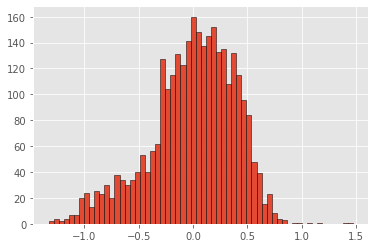

In [91]:
# check residual's distribution
(y_test - y_test_pred).hist(bins = 60,edgecolor='black')

From above, we can see the residual's distribution is nearly normal. Therefore, the trained model is acceptable.

In [96]:
gbt.save_model('gbt.model')

<a id='answerquestion4'></a>
## Answer question 4
- Describe the main factors impacting employee salaries
- Do you think the company has been treating its employees fairly? Do you see any bias?
- What are the next steps you would suggest to the Head of HR?

#### Main factors impacting salaries

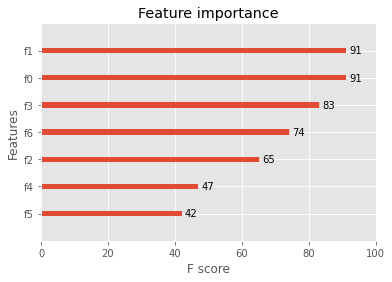

In [97]:
xgb.plot_importance(gbt)

From the above figure, it can be found that the main factors impacting salaries includes: **'years of experience'**, and **'level'**. This is normal, since more experience deserve higher salary, and higher level, more salary.

#### Residuals Analysis

In [103]:
# predict data
whole_matrix = xgb.DMatrix(x_test)
y_pred = gbt.predict(whole_matrix)

predresults = pd.DataFrame({'y_test': np.exp(y_test),'y_pred': np.exp(y_pred)})

# if bias > 0, the employee is over-paid; otherwise, the employee is under paid
predresults['bias'] = predresults.y_test - predresults.y_pred

In [104]:
# join with employee's features
predresults = predresults.join(data)
predresults.head()

,y_test,y_pred,bias,signing_bonus,salary,degree_level,sex,yrs_experience,boss_id,dept,level,counts
employee_id,,,,,,,,,,,,
151440,112000.0,179619.937500,-67619.937500,0,112000.0,High_School,M,4,191073.0,sales,IC,0
28676,99000.0,179619.937500,-80619.937500,0,99000.0,Bachelor,M,2,191485.0,sales,IC,0
75821,367000.0,222665.312500,144334.687500,1,367000.0,Bachelor,M,4,133927.0,engineering,IC,0
65690,286000.0,179817.390625,106182.609375,1,286000.0,Bachelor,M,5,35499.0,sales,IC,0
48120,398000.0,222665.312500,175334.687500,1,398000.0,Master,M,3,140317.0,engineering,MM,12


In [108]:
# delete redundant column
del predresults['y_test']

In [109]:
predresults['bias'].sort_values()

employee_id
17837    -166875.390625
39993    -163875.390625
99006    -162875.390625
176421   -161875.390625
117024   -161665.312500
              ...      
169015    229041.234375
125855    278273.632812
110464    378342.093750
51535     427334.687500
61554     528342.093750
Name: bias, Length: 3000, dtype: float64

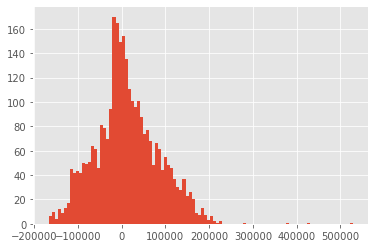

In [110]:
predresults['bias'].hist(bins = 100)

It can be found that the bias is nearly normal.

Text(0, 0.5, 'Bias')

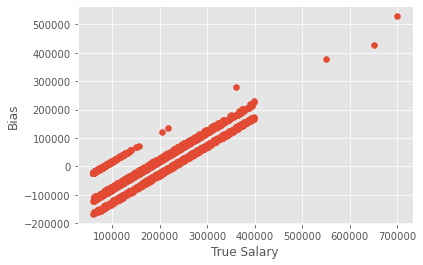

In [112]:
plt.scatter(predresults['salary'], predresults['bias'])
plt.xlabel('True Salary')
plt.ylabel('Bias')

It can be seen that the employee with high salary are more likely to be overpaid.

### Is it fair? Any bias?

In large scope, the company treat its employee fairly. The only bias I can see is that the management level is likely to be overpaid. Higher the level, more likely to be overpaid.